In [2]:
import os
from typing import TypedDict, Optional

from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import START, END, StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# 1. LLM set-up
def groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000,
    )
llm = groq_llm()

In [3]:
# 2. Define State Schema
class PostState(TypedDict, total=False):
    info: dict                        # input information for the post (topic, tone, audience, key points, etc)
    draft: str                        # current draft of the LinkedIn Post
    human_feedback: Optional[str]     # feedback from the human reviewer
    approved: bool                    # wether human reviewer approved
    final_post: Optional[str]         # final approved post content

In [4]:
# 3. Node: Generate initial draft
def generate_draft(state: PostState) -> dict:
    info = state['info']

    # Build prompt based on info
    prompt = f"""You are writing a LinkedIn Post. Here is the info:
    Topic: {info.get('topic')}
    Key points: {info.get('key_points')}
    Tone: {info.get('tone')}
    Audience: {info.get('audience')}
    
    Write a LinkedIn-style post (1-2 short paragraphs) with that info."""

    response = llm.invoke([HumanMessage(content=prompt)])
    draft = response.content.strip()
    print("=== AI Generated Draft ===")
    print(draft)
    return {"draft": draft, "approved": False}

# 4. Node: Ask Human Reviewer for feedback/approval
def ask_for_feedback(state: PostState) -> dict:
    print("\n--- PAUSING FOR HUMAN REVIEW ---")
    print("Draft to review:")
    print(state["draft"])

    # Use inrerrupt to pause and wait for human input
    feedback = interrupt("Please review the draft. Provide feedback (or type 'approved' if OK):")

    # Determine approval based on exact word (Logic can be refined)
    approved = (feedback.strip().lower() == "approved")
    return {"human_feedback": feedback, "approved": approved}

def decide_next(state: PostState) -> str:   # Helper Function
    if state.get("approved", False):
        return "approved"
    else:
        return "revise"

# 5. Node: Revise the draft
def revise_draft(state: PostState) -> dict:
    feedback = state["human_feedback"] or ""
    old_draft = state["draft"]
    prompt = f"""You are re-writing a LinkedIn post. Original darft:
    {old_draft}
    
    Feedback from reviewer:
    {feedback}
    
    Revise the draft accorduingly (keeping the same tone and audience) and output the improved post."""
    response = llm.invoke([HumanMessage(content=prompt)])
    new_draft = response.content.strip()
    print("=== AI Revised Draft ===")
    print(new_draft)
    return {"draft": new_draft, "approved": False}

# 6. Node: Posting the content to LinkedIn
def post_to_linkedin(state: PostState) -> dict:
    final = state["draft"]
    # Making a real LinkedIn call
    # e.g. linkedin_client.post_update(final)

    print("=== POSTING TO LINKEDIN ===")
    print(final)

    # After Posting you can set the final_post
    return {"final_post": final}

In [7]:
# 7. Build the workflow graph
def build_workflow_graph() -> StateGraph:
    builder = StateGraph(PostState)

    builder.add_node("generate_draft", generate_draft)
    builder.add_node("ask_for_feedback", ask_for_feedback)
    builder.add_node("revise_draft", revise_draft)
    builder.add_node("post_to_linkedin", post_to_linkedin)

    # Define edges
    builder.add_edge(START, "generate_draft")
    builder.add_edge("generate_draft", "ask_for_feedback")
    builder.add_conditional_edges(
        "ask_for_feedback",
        decide_next,
        {"approved": "post_to_linkedin", "revise": "revise_draft"}
    )
    builder.add_edge("revise_draft", "ask_for_feedback")
    builder.add_edge("post_to_linkedin", END)

    # Compile with checkpointing to support interrupt/resume
    graph = builder.compile(checkpointer=InMemorySaver())
    return graph

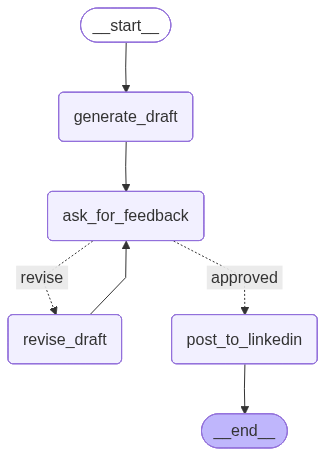

In [8]:
graph = build_workflow_graph()
graph

In [9]:
# 8. Usage / Execution
if __name__ == "__main__":
    input_info = {
        "topic": "Data Science workflow automation with Langgraph",
        "key_points": "human-in-the-loop, agentic workflow, LinkedIn posts, brand voice",
        "tone": "professional yet friendly",
        "audience": "data science and AI practictioners on LinkedIn"
    }

    initial_state: PostState = {
        "info": input_info,
        "draft": "",
        "human_feedback": None,
        "approved": False,
        "final_post": None
    }

    graph = build_workflow_graph()
    thread_id = "linkedin_post_thread_1"
    config = {"configurable": {"thread_id": thread_id}}

    # Start workflow
    result = graph.invoke(initial_state, config=config)

    print("\nWorkflow ended. Final state:")
    print(graph.get_state(config))

=== AI Generated Draft ===
🚀 **Revolutionizing Data Science Workflows with Langgraph**  
As data scientists, we’re constantly juggling data ingestion, feature engineering, model training, and deployment. Langgraph lets us build *agentic workflows* that orchestrate these steps automatically—while keeping a **human‑in‑the‑loop** checkpoint for sanity checks, bias reviews, and domain‑specific tweaks. The result? Faster iterations, fewer bottlenecks, and a workflow that adapts on the fly rather than forcing us to rewrite pipelines for every new project.

👥 **Why this matters for our community**  
By embedding agents that can ask clarifying questions, validate results, and hand off tasks to the right team member, we create a collaborative environment that feels both efficient and accountable. Let’s start sharing our Langgraph‑powered stories on LinkedIn—show how you’re turning complex pipelines into conversational, self‑healing systems. Drop a comment with your biggest workflow pain point, 

### Manual Resume:-
Here we have to make manual resumes for the HITl, we can do this iteratively

### Automatic Loop Resume

In [11]:
# 9. Automatic loop execution
if __name__ == "__main__":
    input_info = {
        "topic": "Data Science workflow automation with Langgraph",
        "key_points": "human-in-the-loop, agentic workflow, LinkedIn posts, brand voice",
        "tone": "professional yet friendly",
        "audience": "data science and AI practictioners on LinkedIn"
    }

    initial_state: PostState = {
        "info": input_info,
        "draft": "",
        "human_feedback": None,
        "approved": False,
        "final_post": None
    }

    graph = build_workflow_graph()
    thread_id = "linkedin_post_thread_1"
    config={"configurable": {"thread_id": thread_id}}

    # Invoke the workflow
    graph.invoke(initial_state, config=config)

    # Loop for human input until workflow ends
    while True:
        state = graph.get_state(config)
        interrupts = getattr(state, "interrupts", None) or []
        if not interrupts:
            # Workflow done
            break
        for intr in interrupts:
            prompt = intr.value if hasattr(intr, "value") else str(intr)
            print(f"\n[interrupt prompt] {prompt}")
            answer = input("Your answer: ")
            graph.invoke(Command(resume={intr.id: answer}), config=config)

    # Final State
    final_state = graph.get_state(config)
    print("\nWorkflow completed. Final state:")
    print(final_state)

=== AI Generated Draft ===
🚀 **Automating the Data Science Workflow with Langgraph**  
Data scientists, you’ve spent countless hours wrangling data, building models, and iterating on experiments. Langgraph lets you turn that repetitive grind into an **agentic workflow**—think of it as a smart, self‑learning pipeline that knows when to pause for your expert judgment (the human‑in‑the‑loop) and when to push forward on its own.  

Whether you’re refining a model, generating insights, or crafting your next LinkedIn post, Langgraph keeps your brand voice consistent and your output scalable. It’s the bridge between rigorous science and real‑world impact, letting you focus on the creative, high‑value parts of your work while the system handles the heavy lifting. Ready to make your workflow smarter? Let’s connect and explore how Langgraph can elevate your projects.

--- PAUSING FOR HUMAN REVIEW ---
Draft to review:
🚀 **Automating the Data Science Workflow with Langgraph**  
Data scientists, yo